# LSTM with stock market data and sentiment

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import sys
import numpy as np
import seaborn as sns
from IPython.display import clear_output
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import src.preprocess_data as preprocess_data
from models.LSenTiMent import LSenTiMent

importlib.reload(preprocess_data)

# Set seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Set PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
# STOCKS_DATA_PATH = "../data/processed/stocks.csv"
STOCKS_DATA_PATH = "../data/apple_stock/AAPL_1980-12-03_2025-03-15.csv"
# SENTIMENT_DATA_PATH = "../data/processed/sentiment140.csv"
SENTIMENT_DATA_PATH = "../data/sentiment-emotion/sentiment-emotion-labelled_Dell_tweets.csv"

FOCUS_PRICE = "Close"
FOCUS_STOCK = "AAPL"

WINDOW_SIZE = 3
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 10000

LSTM_HIDDEN_SIZE = 2
LSTM_NUM_LAYERS = 1

## Data Preparation

### Processing

In [39]:
df_stocks = pd.read_csv(STOCKS_DATA_PATH)

df_stocks.columns = ["Date", "Open", "High", "Low", "Close", "AdjClose", "Volume"]


# TODO: Expand this or use tweets from a larger period of time
# df_stocks = df_stocks[df_stocks["Name"] == FOCUS_STOCK]
# df_stocks = df_stocks[:1000]

df_stocks = df_stocks[["Date", FOCUS_PRICE]]

# df_stocks[FOCUS_PRICE] = (df_stocks[FOCUS_PRICE] - df_stocks[FOCUS_PRICE].min()) / (df_stocks[FOCUS_PRICE].max() - df_stocks[FOCUS_PRICE].min())
df_stocks[FOCUS_PRICE] = (df_stocks[FOCUS_PRICE] - df_stocks[FOCUS_PRICE].mean()) / df_stocks[FOCUS_PRICE].std()

df_stocks["Date"] = df_stocks["Date"].apply(lambda x: x.split(" ")[0])
df_stocks["Date"] = df_stocks["Date"].apply(preprocess_data.convert_date)

df_stocks.set_index("Date", inplace=True)

df_stocks = preprocess_data.apply_time_window(df = df_stocks,
                                              price_col_name=FOCUS_PRICE,
                                              n = WINDOW_SIZE)

print(len(df_stocks))
display(df_stocks.head(10))

11151


,Close,Close-3,Close-2,Close-1
Date,,,,
1980-12-17,-0.483888,-0.483641,-0.483770,-0.483942
1980-12-18,-0.483823,-0.483770,-0.483942,-0.483888
1980-12-19,-0.483684,-0.483942,-0.483888,-0.483823
1980-12-22,-0.483565,-0.483888,-0.483823,-0.483684
1980-12-23,-0.483458,-0.483823,-0.483684,-0.483565
1980-12-24,-0.483318,-0.483684,-0.483565,-0.483458
1980-12-26,-0.483060,-0.483565,-0.483458,-0.483318
1980-12-29,-0.483017,-0.483458,-0.483318,-0.483060
1980-12-30,-0.483093,-0.483318,-0.483060,-0.483017


In [ ]:
# df_sentiment = pd.read_csv(SENTIMENT_DATA_PATH)

# df_sentiment["Datetime"] = pd.to_datetime(df_sentiment["Datetime"])
# df_sentiment["Day"] = df_sentiment["Datetime"].dt.date

# sentiment_map = {
#     'positive': 1,
#     'neutral': 0,
#     'negative': -1
# }

# apple_keywords = ["apple", "iphone", "imac", "macbook", "airpods", "icloud", "appstore", "app store", "appl"]
# apple_keywords = "|".join(apple_keywords)

# df_sentiment["sentiment"] = df_sentiment["sentiment"].map(sentiment_map).astype(float)
# mask = df_sentiment["Text"].str.lower().str.contains(rf"\b({apple_keywords})\b", na=False)
# # df_sentiment.loc[mask, "sentiment"] *= 10
# df_sentiment = df_sentiment[mask]

# mask = df_sentiment["Text"].str.lower().str.contains(r"\b(finance|stock|market|etf|price)\b", na=False)
# df_sentiment.loc[mask, "sentiment"] *= 10

# # df_sentiment.loc[mask, "sentiment"] /= 5000


# daily_sentiment = df_sentiment.groupby("Day")["sentiment"].mean().reset_index()
# daily_sentiment.columns = ["date", "average_sentiment"]

# daily_sentiment['average_sentiment'] = daily_sentiment['average_sentiment'].rolling(window=10, center=True).mean()

# daily_sentiment.set_index("date", inplace=True)

# daily_sentiment = preprocess_data.apply_time_window(df = daily_sentiment,
#                                                     price_col_name = "average_sentiment",
#                                                     n = WINDOW_SIZE)

# daily_sentiment.head()

In [3]:
# df_sentiment = pd.read_csv(SENTIMENT_DATA_PATH)

# df_sentiment["Datetime"] = pd.to_datetime(df_sentiment["Datetime"])
# df_sentiment["Day"] = df_sentiment["Datetime"].dt.date
# daily_sentiment = df_sentiment.groupby("Day")["sentiment_score"].mean().reset_index()
# daily_sentiment.columns = ["date", "average_sentiment"]
# # daily_sentiment['average_sentiment'] = daily_sentiment['average_sentiment'].rolling(window=20, center=True).mean()
# daily_sentiment.set_index("date", inplace=True)

# daily_sentiment.head()

In [4]:
# df_sentiment = pd.read_csv(SENTIMENT_DATA_PATH)

# df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
# df_sentiment['day'] = df_sentiment['date'].dt.date
# daily_sentiment = df_sentiment.groupby('day')['target'].mean().reset_index()
# daily_sentiment.columns = ['date', 'average_sentiment']
# daily_sentiment.set_index("date", inplace=True)

# print(len(daily_sentiment))
# display(daily_sentiment.head(10))

In [4]:
daily_sentiment = pd.read_csv("../data/financial_tweets/financial_tweets_sentiments.csv")
daily_sentiment.columns = ["Date", "description", "average_sentiment"]

apple_keywords = ["apple", "iphone", "imac", "macbook", "airpods", "icloud", "appstore", "app store", "appl"]
apple_keywords = "|".join(apple_keywords)

# mask = daily_sentiment["description"].str.lower().str.contains(rf"\b({apple_keywords})\b", na=False)
# daily_sentiment.loc[mask, "average_sentiment"] *= 10

daily_sentiment = preprocess_data.apply_time_window(df = daily_sentiment,
                                                    price_col_name = "average_sentiment",
                                                    n = WINDOW_SIZE)

daily_sentiment["Date"] = pd.to_datetime(daily_sentiment["Date"])

daily_sentiment.set_index("Date", inplace=True)

daily_sentiment.head()

,description,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
Date,,,,,
2022-01-04,$CRV $SRM\n\nLooking for this new 1D UCTS Buy ...,0.019129,-0.035238,0.056101,0.071395
2022-01-05,$FTM cares zero about your sell off $LINK PAIR...,-0.028683,0.056101,0.071395,0.019129
2022-01-06,RT @ShardiB2: $REFI\n\nBounced off support... ...,-0.046476,0.071395,0.019129,-0.028683
2022-05-19,$ALGO - Lower time frame long. Liking the supe...,0.009375,0.019129,-0.028683,-0.046476
2022-05-20,Next week i have a bunch of exciting and alpha...,-0.072355,-0.028683,-0.046476,0.009375


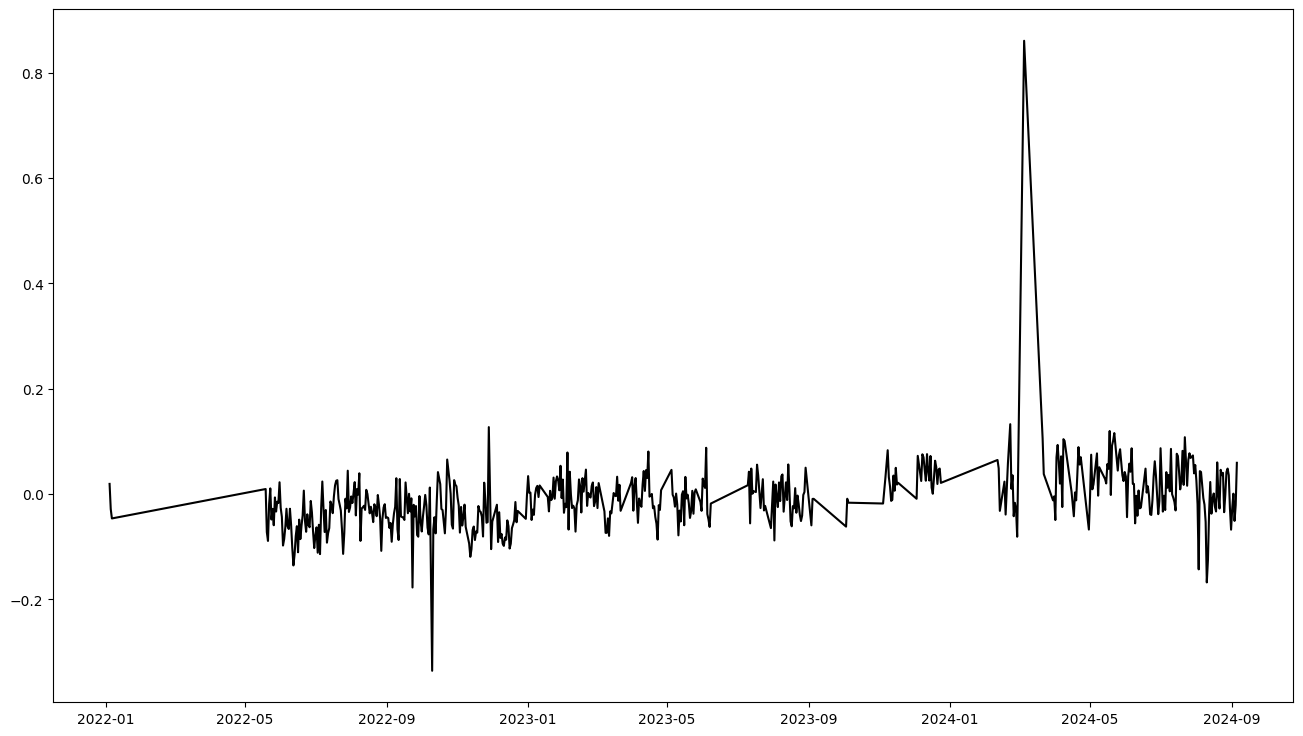

In [5]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(daily_sentiment["average_sentiment"], color="black")

In [6]:
df = pd.merge(df_stocks, daily_sentiment, how="left", left_index=True, right_index=True)
df["average_sentiment"] = df["average_sentiment"].shift(1)
display(df.head())
print(len(df))

,Close,Close-3,Close-2,Close-1,description,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
Date,,,,,,,,,
1980-12-17,-0.483888,-0.483641,-0.483770,-0.483942,NaN,NaN,NaN,NaN,NaN
1980-12-18,-0.483823,-0.483770,-0.483942,-0.483888,NaN,NaN,NaN,NaN,NaN
1980-12-19,-0.483684,-0.483942,-0.483888,-0.483823,NaN,NaN,NaN,NaN,NaN
1980-12-22,-0.483565,-0.483888,-0.483823,-0.483684,NaN,NaN,NaN,NaN,NaN
1980-12-23,-0.483458,-0.483823,-0.483684,-0.483565,NaN,NaN,NaN,NaN,NaN


11151


In [7]:
# df["average_sentiment"] = df["average_sentiment"].fillna(0.5)
df = df[df["average_sentiment"].notna()]
for i in range(1, WINDOW_SIZE + 1):
    df = df[df[f"average_sentiment-{i}"].notna()]
print(len(df))

374


In [34]:
print(df.head())

               Close   Close-3   Close-2   Close-1  \
Date                                                 
2022-01-05  2.882522  2.933556  3.019062  2.974576   
2022-01-06  2.826288  3.019062  2.974576  2.882522   
2022-05-20  2.163615  2.387973  2.225819  2.158994   
2022-05-23  2.269920  2.225819  2.158994  2.163615   
2022-05-24  2.216960  2.158994  2.163615  2.269920   

                                                  description  \
Date                                                            
2022-01-05  $FTM cares zero about your sell off $LINK PAIR...   
2022-01-06  RT @ShardiB2: $REFI\n\nBounced off support... ...   
2022-05-20  Next week i have a bunch of exciting and alpha...   
2022-05-23  Do you think $UNI will revisit 4$ by June 24?\...   
2022-05-24  $BTC Don't mind me; I'm just over here scalpin...   

            average_sentiment  average_sentiment-3  average_sentiment-2  \
Date                                                                      
2022-01-05     

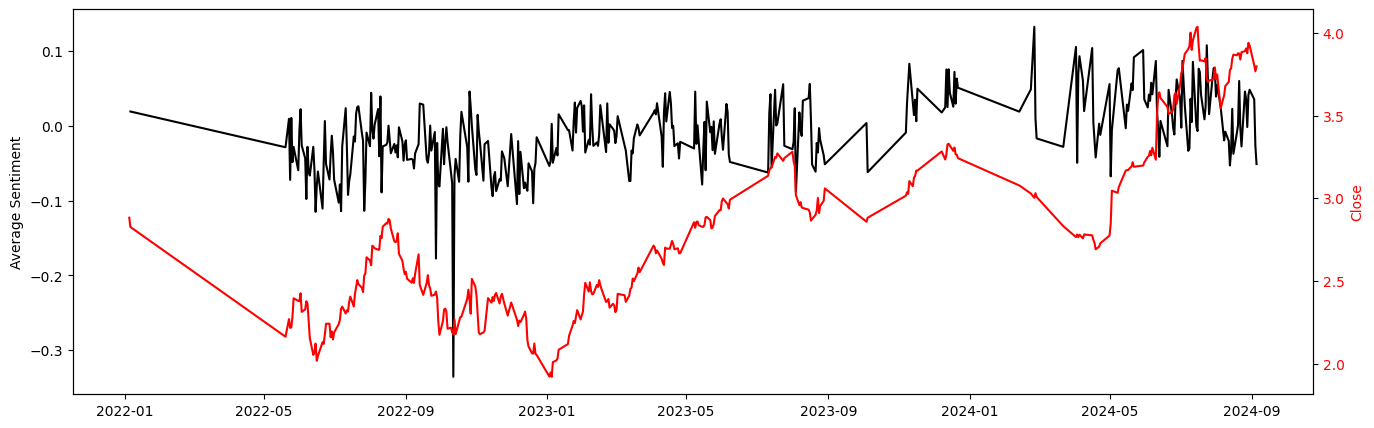

In [8]:
fig, ax1 = plt.subplots(figsize=(16, 5))

df_ = df.copy()
df_["average_sentiment"] = df_["average_sentiment"].shift(1)

ax1.plot(df_["average_sentiment"], color="black", label="Average sentiment")
ax1.set_ylabel("Average Sentiment", color="black")
ax1.tick_params(axis='y', labelcolor="black")

ax2 = ax1.twinx()

ax2.plot(df_[FOCUS_PRICE], color="red", label=FOCUS_PRICE)
ax2.set_ylabel(FOCUS_PRICE, color="red")
ax2.tick_params(axis='y', labelcolor="red")

plt.show()

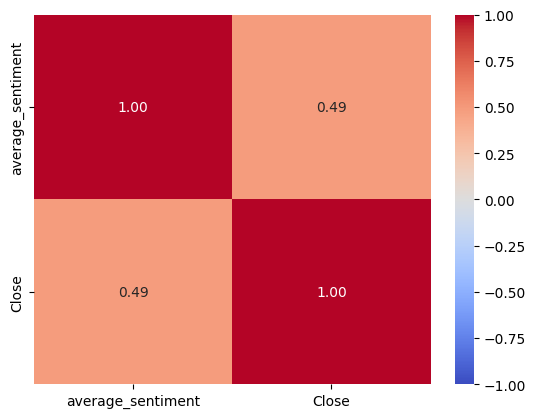

In [9]:
corr = df[["average_sentiment", FOCUS_PRICE]].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.show()

In [10]:
df.head()

,Close,Close-3,Close-2,Close-1,description,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
Date,,,,,,,,,
2022-01-05,2.882522,2.933556,3.019062,2.974576,$FTM cares zero about your sell off $LINK PAIR...,0.019129,0.056101,0.071395,0.019129
2022-01-06,2.826288,3.019062,2.974576,2.882522,RT @ShardiB2: $REFI\n\nBounced off support... ...,-0.028683,0.071395,0.019129,-0.028683
2022-05-20,2.163615,2.387973,2.225819,2.158994,Next week i have a bunch of exciting and alpha...,0.009375,-0.028683,-0.046476,0.009375
2022-05-23,2.269920,2.225819,2.158994,2.163615,Do you think $UNI will revisit 4$ by June 24?\...,-0.072355,-0.072355,-0.089150,-0.018964
2022-05-24,2.216960,2.158994,2.163615,2.269920,$BTC Don't mind me; I'm just over here scalpin...,0.010576,-0.089150,-0.018964,0.010576


### Conversion to PyTorch, data splitting

In [11]:
if "average_sentiment" in df.columns:
    df = df.drop(columns=["average_sentiment"])
if "description" in df.columns:
    df = df.drop(columns=["description"])

Xy = df.to_numpy()
X = Xy[:, 1:]
# X = np.expand_dims(X, axis=-1)
X = np.stack((X[:, :WINDOW_SIZE], X[:, WINDOW_SIZE:]), axis=2)

y = Xy[:, :1]

print(X.shape, y.shape)

(374, 3, 2) (374, 1)


In [ ]:
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

# X = scaler_x.fit_transform(X.reshape(-1, X.shape[-2])).reshape(X.shape)
# y = scaler_y.fit_transform(y)

In [12]:
split = int(len(X) * 0.7)
split2 = int(len(X) * 0.9)

X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:split2], y[split:split2]
X_test, y_test = X[split2:], y[split2:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([261, 3, 2]) torch.Size([261, 1])
torch.Size([75, 3, 2]) torch.Size([75, 1])
torch.Size([38, 3, 2]) torch.Size([38, 1])


### Dataset and DataLoaders

In [13]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [14]:
train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # TODO: Shuffle?
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Modelling

### Model

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sentiment):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.lstm_sentiment = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.mlp = nn.Sequential(
            nn.Linear(WINDOW_SIZE, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

        self.sentiment_mlp = nn.Sequential(
            nn.Linear(WINDOW_SIZE, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        if sentiment:
            self.fc = nn.Linear(hidden_size, 1)
            self.fc1 = nn.Linear(hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)

        self.sentiment = sentiment

    def forward(self, x):
        batch_size = x.size(0)

        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # x_lstm = x[:, :-1, :]

        if self.sentiment:
            x_stock = x[:, :, 0:1]
            x_sentiment = x[:, :, 1:2]

            x_stock, _ = self.lstm(x_stock, (h_0, c_0))
            x_sentiment, _ = self.lstm_sentiment(x_sentiment, (h_0, c_0))

            x_stock = x_stock[:, -1, :]
            x_sentiment = x_sentiment[:, -1, :]
            # print(x_sentiment.shape)
            # x_sentiment = self.sentiment_mlp(x_sentiment.squeeze(-1))

            x_stock = self.fc(x_stock)
            # x_sentiment = self.fc1(x_sentiment)

            # x = x_
            x = torch.cat((x_stock, x_sentiment), dim=1)

            # print(x.shape)
            # return

            x = self.mlp(x)
        else:
            # x = x[:, :WINDOW_SIZE, :]

            x, _ = self.lstm(x, (h_0, c_0))
            x = x[:, -1, :]

            x = self.fc(x)
        
        return x

### Training

In [16]:
def train_model(sentiment=False):
    np.random.seed(0)
    torch.manual_seed(0)

    # if sentiment:
    #     input_size = 2
    # else:
    #     input_size = 1
    input_size = 1

    model = LSTM(input_size=input_size,
             hidden_size=LSTM_HIDDEN_SIZE,
             num_layers=LSTM_NUM_LAYERS,
             sentiment=sentiment).to(device)

    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=LEARNING_RATE)

    best_val_loss = float('inf')
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train(True)

        train_loss = 0
        cnt = 0
        for i, batch in enumerate(train_dataloader):
            X, y = batch[0].to(device), batch[1].to(device)

            if not sentiment:
                X = X[:, :, 0:1]

            out = model(X)
            l = loss(out, y)
            train_loss += l.item()

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            cnt += 1

        train_loss /= cnt

        train_losses.append(train_loss)

        model.train(False)

        val_loss = 0
        cnt = 0
        for i, batch in enumerate(val_dataloader):
            X, y = batch[0].to(device), batch[1].to(device)

            if not sentiment:
                X = X[:, :, 0:1]

            with torch.no_grad():
                out = model(X)
                l = loss(out, y)

                val_loss += l.item()

            cnt += 1

        val_loss /= cnt

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        val_losses.append(val_loss)

        if epoch % 100 == 0:
            clear_output(wait=True)
            print(f"[ Epoch {epoch} / {EPOCHS} ] Train loss = {train_loss} Val loss = {val_loss} Best val loss = {best_val_loss}")
            plt.plot(train_losses, color="black", label="Train loss")
            plt.plot(val_losses, color="red", label="Validation loss")
            plt.yscale("log")
            plt.legend()
            plt.show()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best val loss: {best_val_loss}")

    return model

[ Epoch 9900 / 10000 ] Train loss = 0.0030742001733468738 Val loss = 0.011946924030780792 Best val loss = 0.011946924030780792


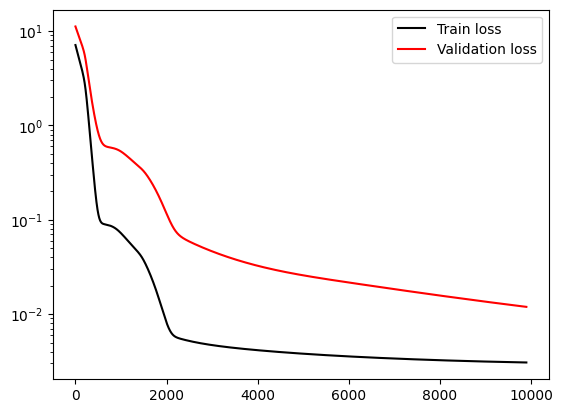

Best val loss: 0.01178690695669502


In [26]:
model_no_sentiment = train_model(sentiment=False)

[ Epoch 9900 / 10000 ] Train loss = 0.0028629162766532425 Val loss = 0.0037008644780144096 Best val loss = 0.0037008644780144096


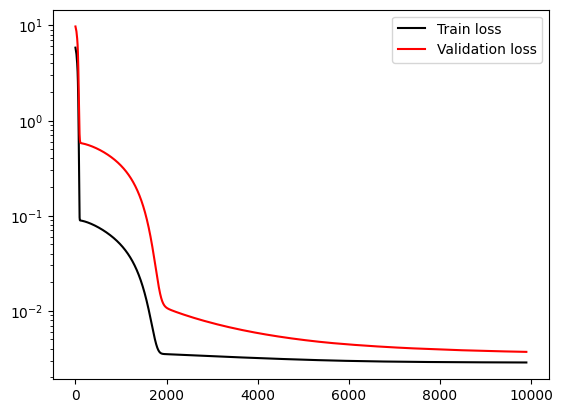

Best val loss: 0.00369307363871485


In [34]:
model_sentiment = train_model(sentiment=True)

## Evaluation

In [35]:
def eval_model(model, sentiment):
    with torch.no_grad():
        if not sentiment:
            X_train_ = X_train[:, :, 0:1]
            X_val_ = X_val[:, :, 0:1]
            X_test_ = X_test[:, :, 0:1]
        else:
            X_train_ = X_train
            X_val_ = X_val
            X_test_ = X_test

        y_train_pred = model(X_train_.to(device)).to("cpu")
        y_train_pred = np.array(y_train_pred)

        y_val_pred = model(X_val_.to(device)).to("cpu")
        y_val_pred = np.array(y_val_pred)

        y_test_pred = model(X_test_.to(device)).to("cpu")
        y_test_pred = np.array(y_test_pred)

    return y_train_pred, y_val_pred, y_test_pred

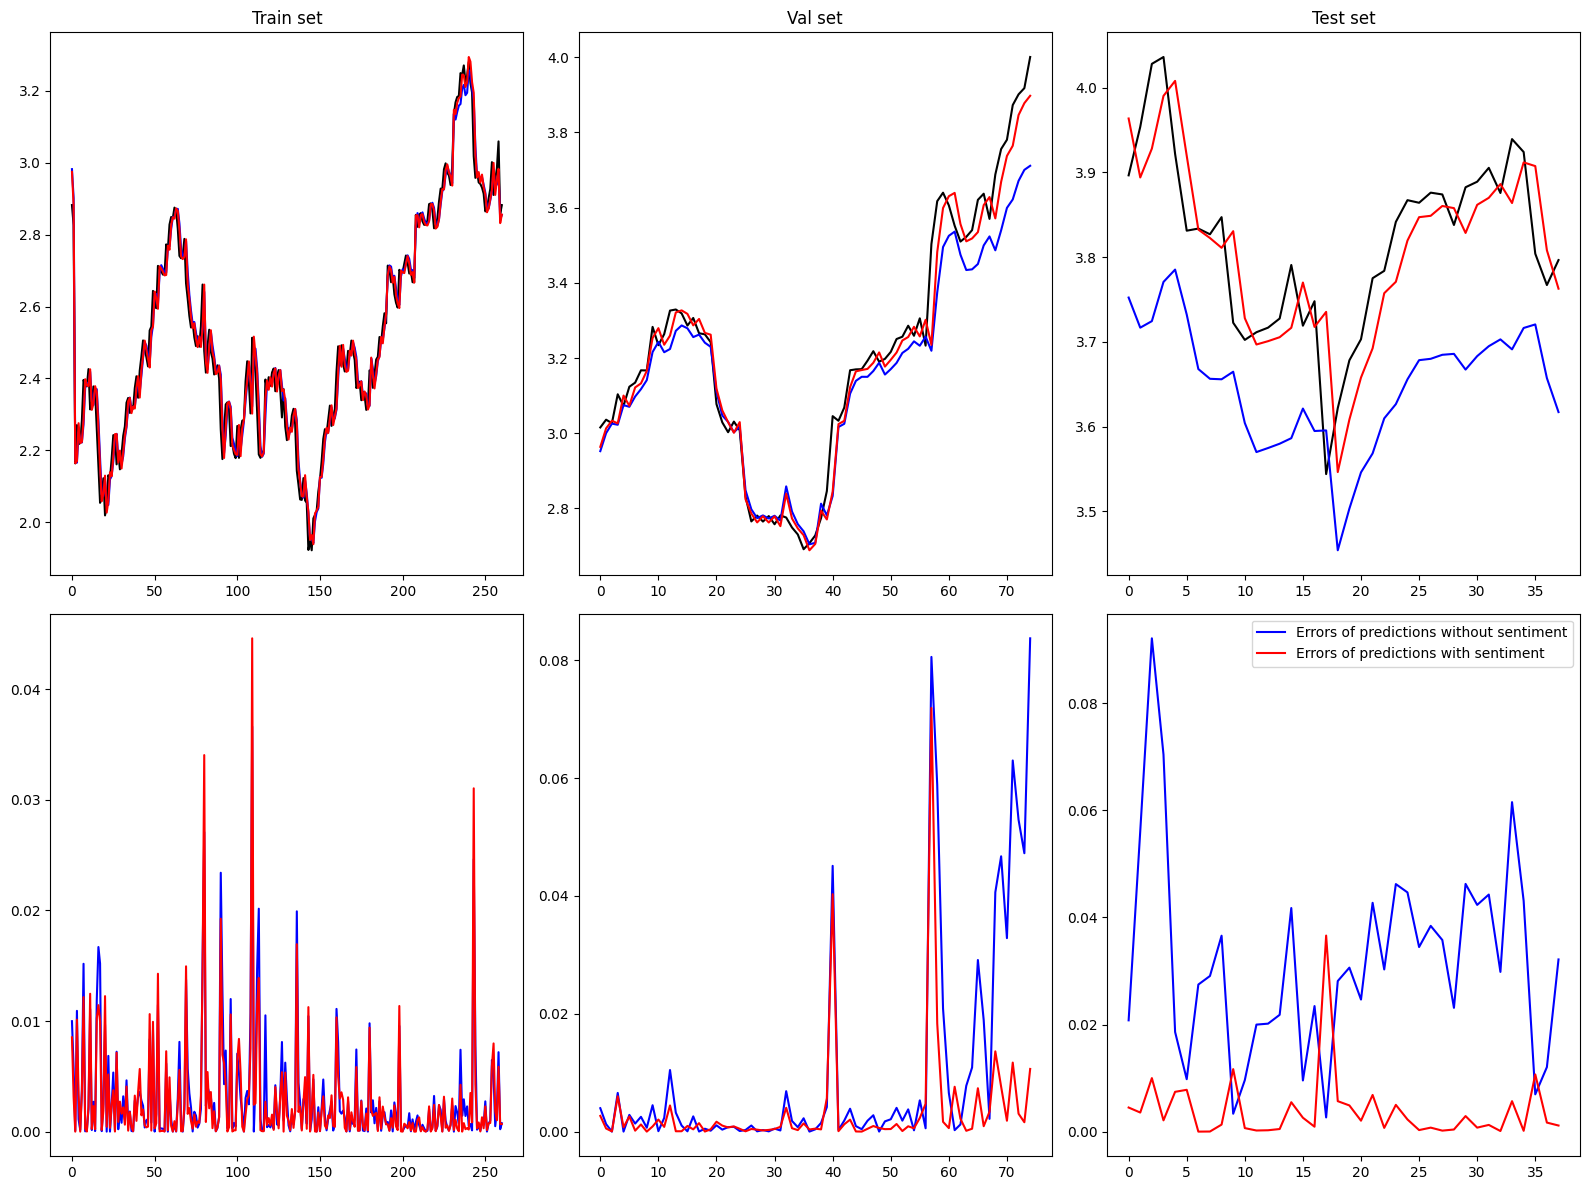

In [36]:
y_train_pred_no_sentiment,y_val_pred_no_sentiment, y_test_pred_no_sentiment = eval_model(model_no_sentiment, sentiment=False)
y_train_pred_sentiment, y_val_pred_sentiment, y_test_pred_sentiment = eval_model(model_sentiment, sentiment=True)

fig, ax = plt.subplots(2, 3, figsize=(16, 12))

ax[0, 0].plot(y_train, color="black", label = "True")
ax[0, 0].plot(y_train_pred_no_sentiment, color="blue", label = "Predictions without sentiment")
ax[0, 0].plot(y_train_pred_sentiment, color="red", label = "Predictions with sentiment")
ax[0, 0].set_title("Train set")

ax[0, 1].plot(y_val, color="black", label = "True")
ax[0, 1].plot(y_val_pred_no_sentiment, color="blue", label = "Predictions without sentiment")
ax[0, 1].plot(y_val_pred_sentiment, color="red", label = "Predictions with sentiment")
ax[0, 1].set_title("Val set")

ax[0, 2].plot(y_test, color="black", label = "True")
ax[0, 2].plot(y_test_pred_no_sentiment, color="blue", label = "Predictions without sentiment")
ax[0, 2].plot(y_test_pred_sentiment, color="red", label = "Predictions with sentiment")
ax[0, 2].set_title("Test set")

ax[1, 0].plot((y_train_pred_no_sentiment - y_train.numpy()) ** 2, color="blue", label = "Errors of predictions without sentiment")
ax[1, 0].plot((y_train_pred_sentiment - y_train.numpy()) ** 2, color="red", label = "Errors of predictions with sentiment")

ax[1, 1].plot((y_val_pred_no_sentiment - y_val.numpy()) ** 2, color="blue", label = "Errors of predictions without sentiment")
ax[1, 1].plot((y_val_pred_sentiment - y_val.numpy()) ** 2, color="red", label = "Errors of predictions with sentiment")

ax[1, 2].plot((y_test_pred_no_sentiment - y_test.numpy()) ** 2, color="blue", label = "Errors of predictions without sentiment")
ax[1, 2].plot((y_test_pred_sentiment - y_test.numpy()) ** 2, color="red", label = "Errors of predictions with sentiment")

plt.legend()
plt.tight_layout()

# TODO: Comparison sentiment vs no sentiment
# TODO: Another lstm for sentiment?
# TODO: Same lstm for sentiment?

# TODO: More weight to sentiments of tweets that contain Apple keywords
# TODO: Take sentiments from the previous few days, not the current day
# TODO: Convolutional NN for feature extraction